In [1]:
# Import modules 
import sys
from os import getcwd
from os.path import dirname
path = dirname(dirname(getcwd()))
sys.path.append(path)

In [2]:
from MintPy.interpret_toolkit import InterpretToolkit
from MintPy.utils import (combine_top_features, 
                          save_pickle, 
                          load_pickle)
import pandas as pd
import numpy as np
from joblib import load

# Load Data and Pre-fit Models 

In [3]:
# Define target feature
TARGET_COLUMN = 'cat_rt'

# Load the model objects. In this case, we are using 3 
# popular models availabe in scikit-learn 
model_fname = ['RandomForest.pkl', 'LogisticRegression.pkl', 'GradientBoostingClassifier.pkl']
model_objs = [load(fname) for fname in model_fname]

# Load the training dataset 
data  = pd.read_csv('example_data.csv')
targets = data[TARGET_COLUMN].values

# only want to use these columns below
cols_to_use = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud',
            'lat_hf', 'low_cloud', 'mid_cloud', 'sat_irbt', 'sens_hf',
            'sfcT_hrs_ab_frez', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
            'swave_flux','temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
            'tot_cloud', 'uplwav_flux','vbd_flux', 'vdd_flux','wind10m',
            'date_marker', 'urban','rural','d_ground','d_rad_d','d_rad_u',
            'hrrr_dT']

units = ['W m$^{-2}$', '$^\circ$C', 'm s$^{-1}$', 'W m$^{-2}$', '%', 'W m$^{-2}$', '%', '%', 
         '$^\circ$C', 'W m$^{-2}$', 'hrs', 'hrs', 'unitless','$^\circ$C', 'W m$^{-2}$', '$^\circ$C', 
         'hrs', 'hrs', '%', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'm s$^{-1}$', 'days', 'unitless', 
         'unitless', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', '$^\circ$C']

pretty_names = [r'$\lambda_{\downarrow}$', '$T_{d}$', '$V_{fric}$', 'Gflux', '$Cloud_{high}$',
 '$Lat_{F}$', '$Cloud_{low}$', '$Cloud_{mid}$', 'IRBT', '$Sens_{F}$',
 'Hours $T_{sfc}$ $> $0', 'Hours $T_{sfc}$ $<= $0', 'SfcRough', '$T_{sfc}$',
 '$I_{S}$', '$T_{2m}$', 'Hours $T_{2m}$ $> $0', 'Hours $T_{2m}$ $<= $0',
 '$Cloud_{Tot}$', r'$\lambda_{\uparrow}$', 'VBD', 'VDD', '10m wind',
 'Date marker', 'Urban', 'Rural', 'Diff1', 'Diff2', 'Diff3',
 '$T_{sfc}$ - $T_{2m}$']

feature_units = {c : u for c,u in zip(cols_to_use, units)}
readable_feature_names = {c : u for c,u in zip(cols_to_use, pretty_names)}

# get predictor subset of dataframe (only the predictors used in training the model)
examples = data[cols_to_use]

/Users/monte.flora/opt/miniconda3/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/monte.flora/opt/miniconda3/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# Initializing InterpretToolkit

To initialize `InterpretToolkit`, requires a pre-fit model object (or multiple models) in one of the following formats: 
* a single pre-fit model object
* list of pre-fit model objects
* A dict of model objects with model names as the key

and examples and targets to evaluate the model(s) on. The examples and targets can be `pandas.DataFrame` or `numpy.array`. If use an array, however, then you must provide the feature names (`'feature_names'`). 

In [4]:
myInterpreter = InterpretToolkit(model=model_objs, 
                             examples=examples, 
                             targets=targets,
                                )

# Permutation Importance

Predictor ranking is often a first step in model interpretability. Permutation importance is a popular model-agnostic method for determining predictor ranking. MintPy uses a stripped-down version of the python package `PermutationImportance` (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). The variation we use is known as the multi-pass permutation importance method (Lakshmanan et al. 2015, JOAT).  The main arguments are the number of important predictors to compute for (`'n_vars'`) and the evaluation function used. 

MintPy has 3 built-in error metrics for evaluating predictor importance: 
* Area under the Curve (`'auc'`)
* Area under the Performance Diagram (`'aupdc'`)
* Brier Skill Score (`'bss'`)


`'evaluation_fn'` can also be any user-defined function of the form 
`evaluation_fn(targets,predictions)` where a single value is returned. 
However, when using your own function, then you must also set the scoring strategy. If a metric is positively-oriented (a higher value is better), then set `scoring_strategy = "argmin_of_mean"` and if is negatively-oriented-oriented (a lower value is better), then set `scoring_strategy = "argmax_of_mean"`. 

 
Additional options for permutation importance include: 
* Performing bootstraping for confidence interval on predictor ranking (`nbootstrap`)
* Using multiple processors for parallelization and speedier results (`njobs`)
* Subsampling the examples for speedier results (`subsample`)

In this example, we want the computing the top 5 predictors using AUC as our error metric and using bootstrapping for confidence intervals. 

In [13]:
results = myInterpreter.permutation_importance(
                                               n_vars=5, 
                                               evaluation_fn='auc', 
                                               nbootstrap=10, 
                                               subsample = 1.0,
                                               njobs=3
                                              )

Processing RandomForestClassifier...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
Starting on the important variable 5 out of 5...
Processing LogisticRegression...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
Starting on the important variable 5 out of 5...
Processing GradientBoostingClassifier...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
Starting on the important variable 5 out of 5...


Once we have the results, we can save them to a pickle file and then load them for later use. When we reload the pickle file, it is important to use the `.set_results` method in `InterpretToolkit` to appropriately set the results as an class attribute. 

In [15]:
# Save the permutation importance results as a pickle file
save_pickle(fname='multipass_importance.pkl',
           data=results)

# Load the permutation important results from the saved pickle file
results = load_pickle(fnames='multipass_importance.pkl')

# Set the permutation importance results as class attribute (for plotting purposes)
myInterpreter.set_results(results=results, 
                          option='permutation_importance'
                         )

# Plotting

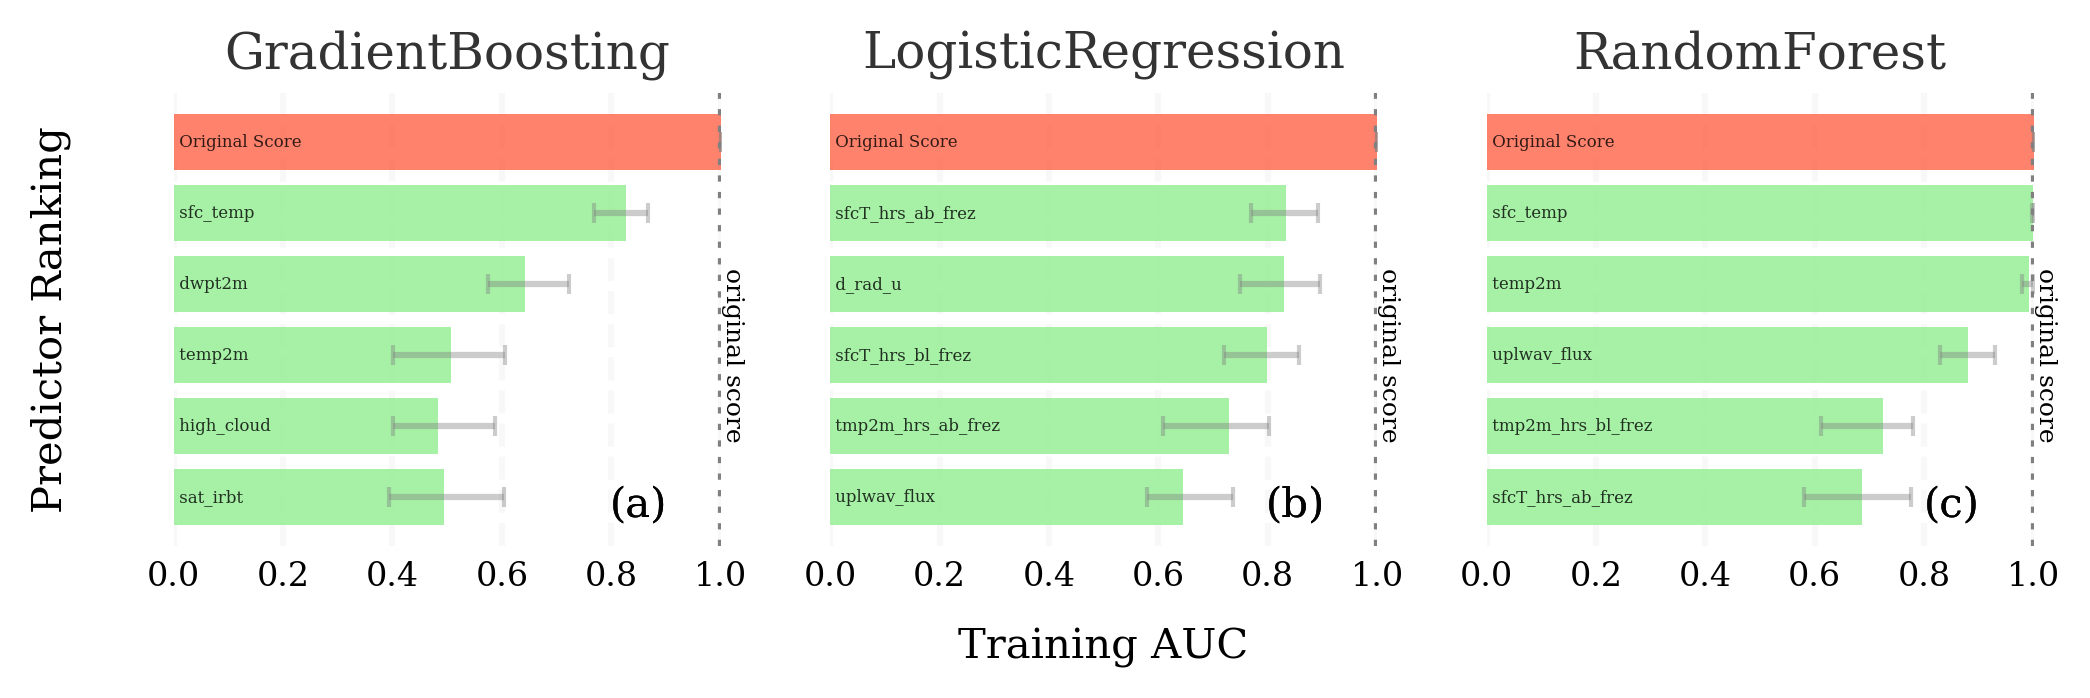

In [16]:
fig = myInterpreter.plot_importance(multipass=True, 
                              metric = "Training AUC",
                              num_vars_to_plot=5)

# Fix the axis labelling for cases with only one panel!!!

In [10]:
# Saving the figures
myInterpreter.save_figure(fig=fig, 
                          fname='multipass_perm_importance.png', 
                          bbox_inches="tight", 
                          dpi=300, aformat="png")